# EEGMamba Finetuning on PhysioNet-MI Dataset

This notebook provides a complete guide for finetuning EEGMamba on the PhysioNet Motor Imagery dataset in Google Colab.

## Dataset Overview
- **Dataset**: PhysioNet Motor Movement/Imagery Dataset (EEG-MMI)
- **Task**: Motor imagery classification (4 classes: left hand, right hand, feet, tongue)
- **Subjects**: 109 subjects (70 train, 19 val, 20 test)
- **Channels**: 64 EEG channels
- **Sampling Rate**: 200 Hz after preprocessing
- **Data Format**: LMDB database with preprocessed epochs



## Step 1: Environment Setup and Dependencies



In [1]:
# Verify all imports work correctly
print("🔍 Testing all critical imports...")

try:
    import torch
    import einops
    import numpy as np
    import scipy
    import sklearn
    import mne
    import lmdb
    print("✅ Basic packages imported successfully!")
    
    # Test the critical ones
    import mamba_ssm
    import causal_conv1d
    print("✅ Mamba-SSM ecosystem imported successfully!")
    
    # Print versions for debugging
    print(f"\n📋 Package versions:")
    print(f"   • PyTorch: {torch.__version__}")
    print(f"   • NumPy: {np.__version__}")
    print(f"   • MNE: {mne.__version__}")
    print(f"   • Mamba-SSM: {mamba_ssm.__version__}")
    
    print("\n🎉 All dependencies are working! Ready to proceed.")
    
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("\n🔧 If you see import errors:")
    print("1. Restart runtime (Runtime → Restart Runtime)")
    print("2. Re-run the installation cells")
    print("3. Check error messages for specific package issues")

🔍 Testing all critical imports...
✅ Basic packages imported successfully!


/home/mahmood/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Mamba-SSM ecosystem imported successfully!

📋 Package versions:
   • PyTorch: 2.5.1+cu121
   • NumPy: 1.26.2
   • MNE: 1.10.2
   • Mamba-SSM: 2.2.6.post3

🎉 All dependencies are working! Ready to proceed.


## Step 2: Data Preprocessing (Optional)

⚠️ **Note**: This step is only needed if you haven't preprocessed your data yet. If you already have the processed LMDB database, skip to Step 3.

The following cell contains the preprocessing script for PhysioNet-MI data. It will:
- Load raw EEG files from PhysioNet dataset
- Apply filtering, rereferencing, and resampling
- Extract motor imagery epochs
- Save to LMDB database format

In [2]:
# PhysioNet-MI Data Preprocessing Script
# Run this only if you need to preprocess raw data

import os
import lmdb
import pickle
import numpy as np
import mne
from tqdm import tqdm

# Configuration
tasks = ['04', '06', '08', '10', '12', '14']  # Motor imagery tasks
root_dir = 'data/raw_motor_movement_Imagery/files'
output_db_path = 'data/'

print("🔧 PhysioNet-MI Preprocessing Configuration:")
print(f"📂 Raw data path: {root_dir}")
print(f"💾 Output database: {output_db_path}")
print(f"🎯 Tasks: {tasks}")

# Check if raw data exists
if not os.path.exists(root_dir):
    print("❌ Raw data directory not found!")
    print("Please ensure PhysioNet data is downloaded to the specified path.")
else:
    print("✅ Raw data directory found!")
    
    # List available subjects
    files = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    files = sorted(files)
    print(f"📊 Found {len(files)} subjects: {files[:5]}...{files[-5:]}")
    
    # Split subjects
    files_dict = {
        'train': files[:70],
        'val': files[70:89], 
        'test': files[89:109],
    }
    
    print(f"📈 Data split: Train={len(files_dict['train'])}, Val={len(files_dict['val'])}, Test={len(files_dict['test'])}")

# Set this to True only if you want to run preprocessing
RUN_PREPROCESSING = False

if RUN_PREPROCESSING:
    print("\n🚀 Starting preprocessing...")
else:
    print("\n⏸️ Preprocessing skipped. Set RUN_PREPROCESSING=True to run.")

🔧 PhysioNet-MI Preprocessing Configuration:
📂 Raw data path: data/raw_motor_movement_Imagery/files
💾 Output database: data/
🎯 Tasks: ['04', '06', '08', '10', '12', '14']
✅ Raw data directory found!
📊 Found 109 subjects: ['S001', 'S002', 'S003', 'S004', 'S005']...['S105', 'S106', 'S107', 'S108', 'S109']
📈 Data split: Train=70, Val=19, Test=20

⏸️ Preprocessing skipped. Set RUN_PREPROCESSING=True to run.


In [3]:
# Actual preprocessing implementation (only runs if enabled above)
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings
if RUN_PREPROCESSING and os.path.exists(root_dir):
    print("🔄 Running preprocessing...")
    
    # EEG channel selection (64 channels)
    selected_channels = [
        'Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 
        'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 
        'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 
        'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 
        'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 
        'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 
        'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 
        'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..'
    ]
    
    # Initialize LMDB database
    db = lmdb.open(output_db_path, map_size=4614542346)
    dataset = {'train': [], 'val': [], 'test': []}
    
    # Process each split
    for split_name, file_list in files_dict.items():
        print(f"\n📊 Processing {split_name} set ({len(file_list)} subjects)...")
        
        for file in tqdm(file_list, desc=f"{split_name}"):
            for task in tasks:
                try:
                    # Load EEG file
                    file_path = os.path.join(root_dir, file, f'{file}R{task}.edf')
                    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
                    
                    # Preprocessing pipeline
                    raw.pick_channels(selected_channels, ordered=True)
                    if len(raw.info['bads']) > 0:
                        raw.interpolate_bads()
                    raw.set_eeg_reference(ref_channels='average')
                    raw.filter(l_freq=0.3, h_freq=None, verbose=False)
                    raw.notch_filter(60, verbose=False)
                    raw.resample(200, verbose=False)
                    
                    # Extract epochs
                    events_from_annot, event_dict = mne.events_from_annotations(raw, verbose=False)
                    epochs = mne.Epochs(raw, events_from_annot, event_dict, 
                                      tmin=0, tmax=4-1.0/raw.info['sfreq'], 
                                      baseline=None, preload=True, verbose=False)
                    
                    # Get data and reshape
                    data = epochs.get_data(units='uV')[:, :, -800:]  # Last 4 seconds at 200Hz
                    events = epochs.events[:, 2]
                    
                    # Reshape to (batch, channels, time_segments, samples_per_segment)
                    bz, ch_nums, _ = data.shape
                    data = data.reshape(bz, ch_nums, 4, 200)
                    
                    # Save to LMDB
                    for i, (sample, event) in enumerate(zip(data, events)):
                        if event != 1:  # Skip rest events
                            sample_key = f'{file}R{task}-{i}'
                            data_dict = {
                                'sample': sample,
                                'label': event - 2 if task in ['04', '08', '12'] else event
                            }
                            txn = db.begin(write=True)
                            txn.put(key=sample_key.encode(), value=pickle.dumps(data_dict))
                            txn.commit()
                            dataset[split_name].append(sample_key)
                            
                except Exception as e:
                    print(f"❌ Error processing {file}R{task}: {str(e)[:100]}...")
                    continue
    
    # Save dataset keys
    txn = db.begin(write=True)
    txn.put(key='__keys__'.encode(), value=pickle.dumps(dataset))
    txn.commit()
    db.close()
    
    print(f"\n✅ Preprocessing complete!")
    print(f"📊 Dataset saved with {sum(len(v) for v in dataset.values())} total samples")
    for split, samples in dataset.items():
        print(f"   {split}: {len(samples)} samples")
        
else:
    if not RUN_PREPROCESSING:
        print("⏸️ Preprocessing skipped")
    else:
        print("❌ Cannot run preprocessing - raw data path not found")

⏸️ Preprocessing skipped


In [4]:
# Verify preprocessed data exists
import os
import pickle

# Check for processed data in Google Drive
data_path = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
print(f"🔍 Checking for processed data at: {data_path}")

if os.path.exists(data_path):
    files = os.listdir(data_path)
    print(f"✅ Processed data directory found!")
    print(f"📁 Contents: {files}")
    
    # Check for LMDB database files
    if 'data.mdb' in files and 'lock.mdb' in files:
        print("✅ LMDB database files present - data is ready for training!")
        
        # Get database info
        import lmdb
        db = lmdb.open(data_path, readonly=True)
        with db.begin() as txn:
            try:
                keys_data = txn.get('__keys__'.encode())
                if keys_data:
                    dataset_keys = pickle.loads(keys_data)
                    print(f"📊 Dataset splits:")
                    for split, samples in dataset_keys.items():
                        print(f"   {split}: {len(samples)} samples")
                    total_samples = sum(len(v) for v in dataset_keys.values())
                    print(f"📈 Total samples: {total_samples}")
                else:
                    print("⚠️ Dataset keys not found in database")
            except:
                print("⚠️ Could not read dataset keys")
        db.close()
    else:
        print("❌ LMDB database files missing - preprocessing needed")
        print("💡 Set RUN_PREPROCESSING=True in the previous cell to create the database")
else:
    print("❌ Processed data directory not found")
    print("💡 Options:")
    print("   1. Set RUN_PREPROCESSING=True above to preprocess data")
    print("   2. Check if the path is correct")
    print("   3. Upload preprocessed data to Google Drive")

🔍 Checking for processed data at: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
✅ Processed data directory found!
📁 Contents: ['lock.mdb', 'data.mdb']
✅ LMDB database files present - data is ready for training!
📊 Dataset splits:
   train: 6300 samples
   val: 1734 samples
   test: 1758 samples
📈 Total samples: 9792


## Step 3: Test Dataset Loading

Let's test the EEGMamba dataset loader to understand our data structure.

In [5]:
print("🧪 Testing EEGMamba dataset loader...")

try:
    from datasets.physio_dataset import LoadDataset
    
    # Create test parameters for dataset loading
    class TestParams:
        def __init__(self):
            self.datasets_dir = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
            self.batch_size = 8
    
    # Initialize dataset loader
    test_params = TestParams()
    print(f"📂 Loading dataset from: {test_params.datasets_dir}")
    
    dataset_loader = LoadDataset(test_params)
    data_loaders = dataset_loader.get_data_loader()
    
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Available data splits: {list(data_loaders.keys())}")
    
    # Test data loading
    for split_name, data_loader in data_loaders.items():
        print(f"\n🔍 Examining {split_name.upper()} set:")
        print(f"   Number of batches: {len(data_loader)}")
        
        # Get first batch to examine data structure
        for batch_idx, (data, labels) in enumerate(data_loader):
            print(f"   ✅ Batch {batch_idx + 1} loaded successfully")
            print(f"   📊 Data shape: {data.shape}")
            print(f"   🎯 Labels shape: {labels.shape}")
            print(f"   📈 Data type: {data.dtype}")
            print(f"   📉 Data range: [{data.min():.3f}, {data.max():.3f}]")
            
            # Check labels
            unique_labels = torch.unique(labels).tolist()
            print(f"   🏷️ Unique labels: {unique_labels}")
            print(f"   📝 Label meanings: 0=left_hand, 1=right_hand, 2=feet, 3=tongue")
            break  # Only examine first batch
        break  # Only examine first split for testing
        
    print("\n🎉 Dataset loading test completed successfully!")
    
except Exception as e:
    print(f"❌ Error testing dataset loader: {e}")
    print("\n🔧 Troubleshooting:")
    print("1. Make sure preprocessed data exists")
    print("2. Check the datasets_dir path")
    print("3. Verify LMDB database integrity")

🧪 Testing EEGMamba dataset loader...
📂 Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
✅ Dataset loaded successfully!
📊 Available data splits: ['train', 'val', 'test']

🔍 Examining TRAIN set:
   Number of batches: 788
   ✅ Batch 1 loaded successfully
   📊 Data shape: torch.Size([8, 64, 4, 200])
   🎯 Labels shape: torch.Size([8])
   📈 Data type: torch.float32
   📉 Data range: [-8.201, 16.395]
   🏷️ Unique labels: [0, 1, 2, 3]
   📝 Label meanings: 0=left_hand, 1=right_hand, 2=feet, 3=tongue

🎉 Dataset loading test completed successfully!


In [6]:
import torch
import matplotlib.pyplot as plt

print("📊 Detailed Data Analysis")

if 'data_loaders' in locals():
    for split_name, data_loader in data_loaders.items():
        print(f"\n--- {split_name.upper()} SET ANALYSIS ---")
        
        all_labels = []
        batch_count = 0
        sample_count = 0
        
        # Analyze several batches
        for batch_idx, (data, labels) in enumerate(data_loader):
            batch_count += 1
            sample_count += data.shape[0]
            all_labels.extend(labels.tolist())
            
            if batch_idx == 0:  # Detailed analysis of first batch
                print(f"📐 Data tensor shape: {data.shape}")
                print(f"   • Batch size: {data.shape[0]}")
                print(f"   • Channels: {data.shape[1]}")
                print(f"   • Time segments: {data.shape[2]}")
                print(f"   • Samples per segment: {data.shape[3]}")
                print(f"   • Total time points: {data.shape[2] * data.shape[3]}")
                print(f"   • Time duration: {data.shape[2] * data.shape[3] / 200:.1f} seconds (at 200 Hz)")
                
            # Don't load all data to save memory
            if batch_idx >= 5:  # Analyze first 5 batches only
                break
                
        # Label distribution
        unique_labels, counts = torch.unique(torch.tensor(all_labels), return_counts=True)
        print(f"\n🏷️ Label Distribution (first {batch_count} batches):")
        label_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
        for label, count in zip(unique_labels.tolist(), counts.tolist()):
            if label < len(label_names):
                print(f"   {label_names[label]} (class {label}): {count} samples")
        
        print(f"📊 Total samples analyzed: {len(all_labels)}")
        
        # Only analyze first split to save time
        break
        
    print("\n✅ Data analysis completed!")
else:
    print("❌ No data loaders available. Please run the previous cell first.")

📊 Detailed Data Analysis

--- TRAIN SET ANALYSIS ---
📐 Data tensor shape: torch.Size([8, 64, 4, 200])
   • Batch size: 8
   • Channels: 64
   • Time segments: 4
   • Samples per segment: 200
   • Total time points: 800
   • Time duration: 4.0 seconds (at 200 Hz)

🏷️ Label Distribution (first 6 batches):
   Left Hand (class 0): 14 samples
   Right Hand (class 1): 10 samples
   Feet (class 2): 12 samples
   Tongue (class 3): 12 samples
📊 Total samples analyzed: 48

✅ Data analysis completed!


## Step 4: FineTuning Configuration

Now let's set up the training parameters for EEGMamba finetuning on PhysioNet-MI.

In [7]:
# EEGMamba Training Configuration
print("⚙️ EEGMamba Training Configuration")

# Dataset and paths
DATASET_NAME = "PhysioNet-MI"
DATASETS_DIR = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
MODEL_DIR = "./results/physio_models"
PRETRAINED_WEIGHTS = "pretrained_weights/pretrained_weights.pth"

# Model parameters
NUM_CLASSES = 4  # Motor imagery classes: left hand, right hand, feet, tongue
CLASSIFIER_TYPE = "all_patch_reps"  # EEGMamba classifier type

# Training hyperparameters
EPOCHS = 50  
BATCH_SIZE = 32 
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-2
CUDA_DEVICE = 0

# Advanced options
OPTIMIZER = "AdamW"
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1
USE_PRETRAINED = True

print("📋 Configuration Summary:")
print(f"   🎯 Dataset: {DATASET_NAME}")
print(f"   📂 Data path: {DATASETS_DIR}")
print(f"   🏷️ Classes: {NUM_CLASSES}")
print(f"   🏃 Epochs: {EPOCHS}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   📈 Learning rate: {LEARNING_RATE}")
print(f"   💾 Model save dir: {MODEL_DIR}")
print(f"   🎭 Use pretrained: {USE_PRETRAINED}")

# Verify pretrained weights exist
if USE_PRETRAINED:
    if os.path.exists(PRETRAINED_WEIGHTS):
        print(f"   ✅ Pretrained weights found: {PRETRAINED_WEIGHTS}")
    else:
        print(f"   ⚠️ Pretrained weights not found: {PRETRAINED_WEIGHTS}")
        print("   💡 Will train from scratch or download weights")

# Create results directory
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"   📁 Results directory ready: {MODEL_DIR}")

⚙️ EEGMamba Training Configuration
📋 Configuration Summary:
   🎯 Dataset: PhysioNet-MI
   📂 Data path: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
   🏷️ Classes: 4
   🏃 Epochs: 50
   📦 Batch size: 32
   📈 Learning rate: 0.0001
   💾 Model save dir: ./results/physio_models
   🎭 Use pretrained: True
   ⚠️ Pretrained weights not found: pretrained_weights/pretrained_weights.pth
   💡 Will train from scratch or download weights
   📁 Results directory ready: ./results/physio_models


In [8]:
# Quick environment check before training
print("🔍 Pre-training Environment Check")

# Check GPU availability
if torch.cuda.is_available():
    print(f"✅ CUDA available: {torch.cuda.get_device_name(0)}")
    print(f"   GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ CUDA not available - training will be slow on CPU")

# Check key files
key_files = {
    'finetune_main.py': 'Main training script',
    'models/': 'Model definitions',
    'datasets/': 'Dataset loaders',
    'pretrained_weights/': 'Pretrained weights'
}

for file_path, description in key_files.items():
    if os.path.exists(file_path):
        print(f"✅ {description}: {file_path}")
    else:
        print(f"❌ Missing {description}: {file_path}")

# Check if we can import the model
try:
    from models.model_for_physio import Model
    print("✅ PhysioNet model import successful")
except Exception as e:
    print(f"❌ Model import failed: {e}")

print("\n🚀 Ready for training!")

🔍 Pre-training Environment Check
✅ CUDA available: NVIDIA RTX A4000
   GPU memory: 16.8 GB
✅ Main training script: finetune_main.py
✅ Model definitions: models/
✅ Dataset loaders: datasets/
✅ Pretrained weights: pretrained_weights/
✅ PhysioNet model import successful

🚀 Ready for training!


## Step 5: FineTune Run


In [9]:
# Quick test command
test_command = f"""
python finetune_main.py \
    --downstream_dataset {DATASET_NAME} \
    --datasets_dir {DATASETS_DIR} \
    --num_of_classes {NUM_CLASSES} \
    --model_dir {MODEL_DIR}_test \
    --epochs 50 \
    --batch_size 32 \
    --lr {LEARNING_RATE} \
    --weight_decay {WEIGHT_DECAY} \
    --cuda {CUDA_DEVICE} \
    --use_pretrained_weights True \
    --foundation_dir {PRETRAINED_WEIGHTS}
"""

print("Quick Test Command:")
print(test_command.strip())
print("\n📝 Copy and run this command in terminal to test the setup!")

Quick Test Command:
python finetune_main.py     --downstream_dataset PhysioNet-MI     --datasets_dir /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average     --num_of_classes 4     --model_dir ./results/physio_models_test     --epochs 50     --batch_size 32     --lr 0.0001     --weight_decay 0.05     --cuda 0     --use_pretrained_weights True     --foundation_dir pretrained_weights/pretrained_weights.pth

📝 Copy and run this command in terminal to test the setup!


In [17]:
!python finetune_main.py     --downstream_dataset PhysioNet-MI     --datasets_dir /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average     --num_of_classes 4     --model_dir ./results/physio_models_test     --epochs 50     --batch_size 32     --lr 0.0001     --weight_decay 0.05     --cuda 0     --use_pretrained_weights True     --foundation_dir pretrained_weights/pretrained_weights.pth


Namespace(seed=3407, cuda=0, epochs=50, batch_size=32, lr=0.0001, weight_decay=0.05, optimizer='AdamW', clip_value=1, dropout=0.1, classifier='all_patch_reps', downstream_dataset='PhysioNet-MI', datasets_dir='/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average', num_of_classes=4, model_dir='./results/physio_models_test', num_workers=16, label_smoothing=0.1, multi_lr=True, frozen=False, use_pretrained_weights=True, foundation_dir='pretrained_weights/pretrained_weights.pth')
The downstream dataset is PhysioNet-MI
6300 1734 1758
9792
/home/mahmood/HosseinDahaei/Codes/EEGMamba/models/model_for_physio.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

## Step 6: Visualize Training Progress

After training completes, use this cell to visualize the training metrics over epochs.

🔍 Looking for training log...
✅ Found log file: ./results/physio_models_test/training_log.json
📂 Loading training log from: ./results/physio_models_test/training_log.json
✅ Log loaded successfully!
📊 Total epochs trained: 50


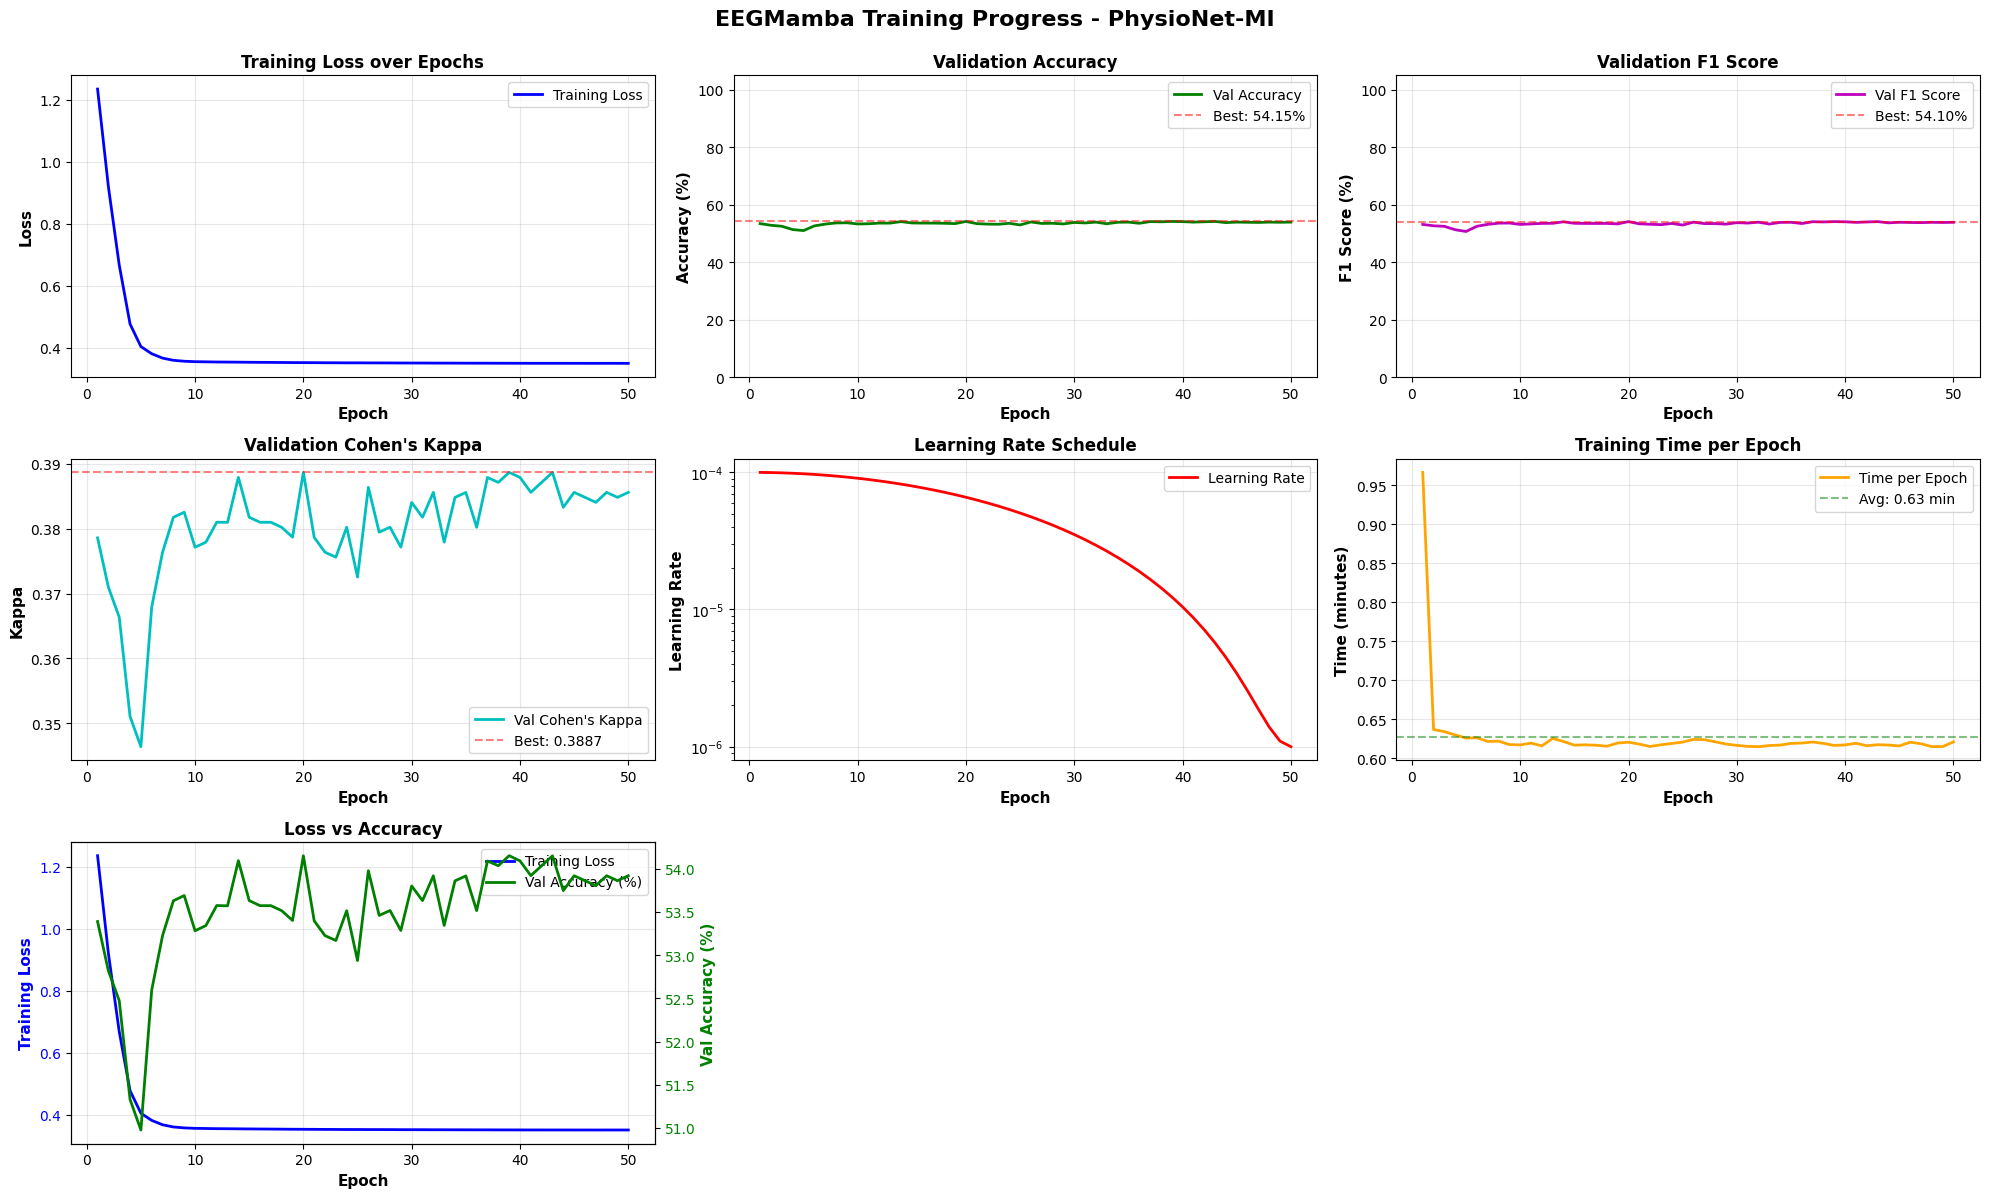


📊 TRAINING SUMMARY

🕒 Training Duration:
   Total epochs: 50
   Total time: 31.33 minutes (0.52 hours)
   Avg time per epoch: 0.63 minutes

📈 Training Loss:
   Initial: 1.23511
   Final: 0.35019
   Best (min): 0.35016
   Reduction: 71.65%

🎯 Validation Accuracy:
   Initial: 53.39%
   Final: 53.92%
   Best: 54.15%
   Best epoch: 39
   Improvement: +0.53 percentage points

📊 Validation Kappa:
   Initial: 0.3786
   Final: 0.3856
   Best: 0.3887
   Best epoch: 39

📈 Validation F1 Score:
   Initial: 53.11%
   Final: 53.85%
   Best: 54.10%
   Best epoch: 43

🏆 TEST SET RESULTS (Best Model):
   Best epoch: 39
   Accuracy: 58.13%
   Kappa: 0.4410
   F1 Score: 57.97%




In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_training_progress(log_file_path):
    """
    Plot training progress from the saved training log
    
    Args:
        log_file_path: Path to the training_log.json file
    """
    
    # Check if log file exists
    if not os.path.exists(log_file_path):
        print(f"❌ Training log not found at: {log_file_path}")
        print("💡 Please make sure training has completed and the log file was created")
        return
    
    # Load training log
    print(f"📂 Loading training log from: {log_file_path}")
    with open(log_file_path, 'r') as f:
        history = json.load(f)
    
    print(f"✅ Log loaded successfully!")
    print(f"📊 Total epochs trained: {len(history['train_loss'])}")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Training Loss
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss')
    ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax1.set_title('Training Loss over Epochs', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # 2. Validation Accuracy
    if history['val_acc']:
        ax2 = plt.subplot(3, 3, 2)
        ax2.plot(epochs, [acc * 100 for acc in history['val_acc']], 'g-', linewidth=2, label='Val Accuracy')
        ax2.axhline(y=max(history['val_acc']) * 100, color='r', linestyle='--', alpha=0.5, label=f'Best: {max(history["val_acc"])*100:.2f}%')
        ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Validation Accuracy', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        ax2.set_ylim([0, 105])
    
    # 3. Validation F1 Score (if available)
    if history.get('val_f1') and any(history['val_f1']):
        ax3 = plt.subplot(3, 3, 3)
        ax3.plot(epochs, [f1 * 100 for f1 in history['val_f1']], 'm-', linewidth=2, label='Val F1 Score')
        ax3.axhline(y=max(history['val_f1']) * 100, color='r', linestyle='--', alpha=0.5, label=f'Best: {max(history["val_f1"])*100:.2f}%')
        ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax3.set_ylabel('F1 Score (%)', fontsize=11, fontweight='bold')
        ax3.set_title('Validation F1 Score', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.legend(fontsize=10)
        ax3.set_ylim([0, 105])
    
    # 4. Validation Kappa (if available)
    if history.get('val_kappa') and any(history['val_kappa']):
        ax4 = plt.subplot(3, 3, 4)
        ax4.plot(epochs, history['val_kappa'], 'c-', linewidth=2, label='Val Cohen\'s Kappa')
        ax4.axhline(y=max(history['val_kappa']), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(history["val_kappa"]):.4f}')
        ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Kappa', fontsize=11, fontweight='bold')
        ax4.set_title('Validation Cohen\'s Kappa', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=10)
    
    # 5. Learning Rate
    if history['learning_rate']:
        ax5 = plt.subplot(3, 3, 5)
        ax5.plot(epochs, history['learning_rate'], 'r-', linewidth=2, label='Learning Rate')
        ax5.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax5.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
        ax5.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
        ax5.grid(True, alpha=0.3)
        ax5.legend(fontsize=10)
        ax5.set_yscale('log')
    
    # 6. Epoch Time
    if history['epoch_time']:
        ax6 = plt.subplot(3, 3, 6)
        ax6.plot(epochs, history['epoch_time'], 'orange', linewidth=2, label='Time per Epoch')
        ax6.axhline(y=np.mean(history['epoch_time']), color='g', linestyle='--', alpha=0.5, label=f'Avg: {np.mean(history["epoch_time"]):.2f} min')
        ax6.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax6.set_ylabel('Time (minutes)', fontsize=11, fontweight='bold')
        ax6.set_title('Training Time per Epoch', fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        ax6.legend(fontsize=10)
    
    # 7. Combined Metrics (Loss + Accuracy)
    ax7 = plt.subplot(3, 3, 7)
    ax7_twin = ax7.twinx()
    
    line1 = ax7.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss')
    if history['val_acc']:
        line2 = ax7_twin.plot(epochs, [acc * 100 for acc in history['val_acc']], 'g-', linewidth=2, label='Val Accuracy (%)')
    
    ax7.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Training Loss', fontsize=11, fontweight='bold', color='b')
    ax7_twin.set_ylabel('Val Accuracy (%)', fontsize=11, fontweight='bold', color='g')
    ax7.set_title('Loss vs Accuracy', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    ax7.tick_params(axis='y', labelcolor='b')
    ax7_twin.tick_params(axis='y', labelcolor='g')
    
    # Combine legends
    lines = line1
    if history['val_acc']:
        lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax7.legend(lines, labels, loc='upper right', fontsize=10)
    
    # 8. Binary classification metrics (if available)
    if history.get('val_roc_auc') and any(history['val_roc_auc']):
        ax8 = plt.subplot(3, 3, 8)
        ax8.plot(epochs, [auc * 100 for auc in history['val_roc_auc']], 'purple', linewidth=2, label='ROC AUC')
        if history.get('val_pr_auc') and any(history['val_pr_auc']):
            ax8.plot(epochs, [auc * 100 for auc in history['val_pr_auc']], 'brown', linewidth=2, label='PR AUC')
        ax8.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax8.set_ylabel('AUC (%)', fontsize=11, fontweight='bold')
        ax8.set_title('Validation AUC Metrics', fontsize=12, fontweight='bold')
        ax8.grid(True, alpha=0.3)
        ax8.legend(fontsize=10)
        ax8.set_ylim([0, 105])
    
    # 9. Regression metrics (if available)
    if history.get('val_r2') and any(history['val_r2']):
        ax9 = plt.subplot(3, 3, 9)
        ax9.plot(epochs, history['val_r2'], 'teal', linewidth=2, label='R² Score')
        if history.get('val_corrcoef') and any(history['val_corrcoef']):
            ax9.plot(epochs, history['val_corrcoef'], 'navy', linewidth=2, label='Correlation Coef')
        ax9.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax9.set_ylabel('Score', fontsize=11, fontweight='bold')
        ax9.set_title('Validation Regression Metrics', fontsize=12, fontweight='bold')
        ax9.grid(True, alpha=0.3)
        ax9.legend(fontsize=10)
    
    plt.suptitle('EEGMamba Training Progress - PhysioNet-MI', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("📊 TRAINING SUMMARY")
    print("="*80)
    print(f"\n🕒 Training Duration:")
    print(f"   Total epochs: {len(history['train_loss'])}")
    print(f"   Total time: {sum(history['epoch_time']):.2f} minutes ({sum(history['epoch_time'])/60:.2f} hours)")
    print(f"   Avg time per epoch: {np.mean(history['epoch_time']):.2f} minutes")
    
    print(f"\n📈 Training Loss:")
    print(f"   Initial: {history['train_loss'][0]:.5f}")
    print(f"   Final: {history['train_loss'][-1]:.5f}")
    print(f"   Best (min): {min(history['train_loss']):.5f}")
    print(f"   Reduction: {(1 - history['train_loss'][-1]/history['train_loss'][0])*100:.2f}%")
    
    if history['val_acc']:
        print(f"\n🎯 Validation Accuracy:")
        print(f"   Initial: {history['val_acc'][0]*100:.2f}%")
        print(f"   Final: {history['val_acc'][-1]*100:.2f}%")
        print(f"   Best: {max(history['val_acc'])*100:.2f}%")
        print(f"   Best epoch: {history['val_acc'].index(max(history['val_acc'])) + 1}")
        print(f"   Improvement: {(history['val_acc'][-1] - history['val_acc'][0])*100:+.2f} percentage points")
    
    if history.get('val_kappa') and any(history['val_kappa']):
        print(f"\n📊 Validation Kappa:")
        print(f"   Initial: {history['val_kappa'][0]:.4f}")
        print(f"   Final: {history['val_kappa'][-1]:.4f}")
        print(f"   Best: {max(history['val_kappa']):.4f}")
        print(f"   Best epoch: {history['val_kappa'].index(max(history['val_kappa'])) + 1}")
    
    if history.get('val_f1') and any(history['val_f1']):
        print(f"\n📈 Validation F1 Score:")
        print(f"   Initial: {history['val_f1'][0]*100:.2f}%")
        print(f"   Final: {history['val_f1'][-1]*100:.2f}%")
        print(f"   Best: {max(history['val_f1'])*100:.2f}%")
        print(f"   Best epoch: {history['val_f1'].index(max(history['val_f1'])) + 1}")
    
    # Test results
    if history.get('test_results'):
        print(f"\n🏆 TEST SET RESULTS (Best Model):")
        test_res = history['test_results']
        print(f"   Best epoch: {test_res.get('best_epoch', 'N/A')}")
        
        if 'acc' in test_res:
            print(f"   Accuracy: {test_res['acc']*100:.2f}%")
        if 'kappa' in test_res:
            print(f"   Kappa: {test_res['kappa']:.4f}")
        if 'f1' in test_res:
            print(f"   F1 Score: {test_res['f1']*100:.2f}%")
        if 'roc_auc' in test_res:
            print(f"   ROC AUC: {test_res['roc_auc']*100:.2f}%")
        if 'pr_auc' in test_res:
            print(f"   PR AUC: {test_res['pr_auc']*100:.2f}%")
        if 'r2' in test_res:
            print(f"   R² Score: {test_res['r2']:.4f}")
        if 'corrcoef' in test_res:
            print(f"   Correlation: {test_res['corrcoef']:.4f}")
    
    print("\n" + "="*80 + "\n")
    
    return history


# Example usage - modify the path to your training log
LOG_FILE = "./results/physio_models_test/training_log.json"

print("🔍 Looking for training log...")
if os.path.exists(LOG_FILE):
    print(f"✅ Found log file: {LOG_FILE}")
    history = plot_training_progress(LOG_FILE)
else:
    print(f"⚠️ Log file not found at: {LOG_FILE}")
    print("\n💡 Alternative locations to check:")
    
    # Search for training logs in common locations
    possible_dirs = [
        "./results/physio_models",
        "./results/physio_models_test",
        "./results"
    ]
    
    found_logs = []
    for search_dir in possible_dirs:
        if os.path.exists(search_dir):
            for root, dirs, files in os.walk(search_dir):
                if 'training_log.json' in files:
                    found_logs.append(os.path.join(root, 'training_log.json'))
    
    if found_logs:
        print("\n📂 Found training logs:")
        for i, log_path in enumerate(found_logs, 1):
            print(f"   {i}. {log_path}")
        print(f"\n💡 To visualize a specific log, run:")
        print(f"   history = plot_training_progress('{found_logs[0]}')")
    else:
        print("   No training logs found yet.")
        print("   Training logs will be created automatically after running the finetuning process.")


## Step 7: Evaluate Pretrained Model (Zero-Shot Evaluation)

This section will evaluate the pretrained EEGMamba model on PhysioNet-MI **without any training** to get the baseline accuracy of the pretrained weights.

In [19]:
# Direct in-notebook testing of pretrained model
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, cohen_kappa_score

def test_pretrained_directly():
    """Test pretrained model directly in notebook"""
    
    print("🧪 Direct Pretrained Model Evaluation")
    print("="*80)
    
    # Import required modules
    from datasets.physio_dataset import LoadDataset
    from models.model_for_physio import Model
    
    # Create parameters object
    class TestParams:
        def __init__(self):
            self.datasets_dir = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
            self.batch_size = 32
            self.num_workers = 8
            self.downstream_dataset = 'PhysioNet-MI'
            self.num_of_classes = 4
            self.use_pretrained_weights = True
            self.foundation_dir = "pretrained_weights/pretrained_weights.pth"
            self.classifier = 'all_patch_reps'
            self.dropout = 0.1
            self.seed = 3407
            self.cuda = 0  # CUDA device number
    
    params = TestParams()
    
    # Set device
    device = torch.device(f'cuda:{params.cuda}' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Load dataset
    print(f"Loading dataset from: {params.datasets_dir}")
    load_dataset = LoadDataset(params)
    data_loaders = load_dataset.get_data_loader()
    print(f"Available splits: {list(data_loaders.keys())}\n")
    
    # Load model
    print("Loading model with pretrained weights...")
    model = Model(params)
    model = model.to(device)
    model.eval()
    print("Model loaded successfully!\n")
    
    # Test on each split
    results = {}
    
    for split_name in ['train', 'val', 'test']:
        if split_name not in data_loaders:
            continue
        
        print(f"{'='*80}")
        print(f"Testing on {split_name.upper()} set")
        print(f"{'='*80}")
        
        truths = []
        preds = []
        
        with torch.no_grad():
            for x, y in tqdm(data_loaders[split_name], desc=f"Evaluating {split_name}"):
                x = x.to(device)
                y = y.to(device)
                
                pred = model(x)
                pred_y = torch.max(pred, dim=-1)[1]
                
                truths.extend(y.cpu().numpy().tolist())
                preds.extend(pred_y.cpu().numpy().tolist())
        
        # Calculate metrics
        truths = np.array(truths)
        preds = np.array(preds)
        
        acc = balanced_accuracy_score(truths, preds)
        f1 = f1_score(truths, preds, average='weighted')
        kappa = cohen_kappa_score(truths, preds)
        cm = confusion_matrix(truths, preds)
        
        results[split_name] = {
            'accuracy': acc,
            'f1': f1,
            'kappa': kappa,
            'confusion_matrix': cm,
            'num_samples': len(truths)
        }
        
        # Print results
        print(f"\n📊 {split_name.upper()} Results:")
        print(f"  • Balanced Accuracy: {acc*100:.2f}%")
        print(f"  • F1 Score (Weighted): {f1*100:.2f}%")
        print(f"  • Cohen's Kappa: {kappa:.4f}")
        print(f"  • Total Samples: {len(truths)}")
        
        print(f"\n📋 Confusion Matrix:")
        print(cm)
        
        # Per-class metrics
        print(f"\n🎯 Per-Class Accuracy:")
        class_names = ['Left Hand (0)', 'Right Hand (1)', 'Feet (2)', 'Tongue (3)']
        for i, class_name in enumerate(class_names):
            if i < cm.shape[0] and cm[i, :].sum() > 0:
                class_acc = cm[i, i] / cm[i, :].sum()
                class_samples = cm[i, :].sum()
                print(f"  {class_name:20s}: {class_acc*100:6.2f}% ({int(class_samples)} samples)")
        
        print()
    
    # Summary
    print(f"\n{'='*80}")
    print("📈 FINAL SUMMARY - Pretrained Model Performance")
    print(f"{'='*80}")
    print(f"{'Split':<10} {'Accuracy':<12} {'F1 Score':<12} {'Kappa':<10} {'Samples'}")
    print("-"*80)
    
    for split_name in ['train', 'val', 'test']:
        if split_name in results:
            r = results[split_name]
            print(f"{split_name.upper():<10} {r['accuracy']*100:6.2f}%      {r['f1']*100:6.2f}%      {r['kappa']:6.4f}    {r['num_samples']}")
    
    print(f"{'='*80}\n")
    
    return results

# Run the test
try:
    results = test_pretrained_directly()
    print("✅ Pretrained model evaluation completed!")
except Exception as e:
    print(f"❌ Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

🧪 Direct Pretrained Model Evaluation
Using device: cuda:0

Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
Available splits: ['train', 'val', 'test']

Loading model with pretrained weights...
Model loaded successfully!

Testing on TRAIN set


Evaluating train: 100%|██████████| 197/197 [00:16<00:00, 11.98it/s]



📊 TRAIN Results:
  • Balanced Accuracy: 25.01%
  • F1 Score (Weighted): 13.95%
  • Cohen's Kappa: 0.0000
  • Total Samples: 6300

📋 Confusion Matrix:
[[ 170    0    9 1414]
 [ 202    0   23 1332]
 [ 199    1   16 1365]
 [ 166    0   17 1386]]

🎯 Per-Class Accuracy:
  Left Hand (0)       :  10.67% (1593 samples)
  Right Hand (1)      :   0.00% (1557 samples)
  Feet (2)            :   1.01% (1581 samples)
  Tongue (3)          :  88.34% (1569 samples)

Testing on VAL set


Evaluating val: 100%|██████████| 55/55 [00:02<00:00, 21.40it/s]



📊 VAL Results:
  • Balanced Accuracy: 24.64%
  • F1 Score (Weighted): 14.12%
  • Cohen's Kappa: -0.0048
  • Total Samples: 1734

📋 Confusion Matrix:
[[ 49   0   4 382]
 [ 57   0   1 374]
 [ 78   0   7 349]
 [ 57   0   5 371]]

🎯 Per-Class Accuracy:
  Left Hand (0)       :  11.26% (435 samples)
  Right Hand (1)      :   0.00% (432 samples)
  Feet (2)            :   1.61% (434 samples)
  Tongue (3)          :  85.68% (433 samples)

Testing on TEST set


Evaluating test: 100%|██████████| 55/55 [00:02<00:00, 20.84it/s]


📊 TEST Results:
  • Balanced Accuracy: 23.93%
  • F1 Score (Weighted): 13.72%
  • Cohen's Kappa: -0.0144
  • Total Samples: 1758

📋 Confusion Matrix:
[[ 43   0   3 391]
 [ 47   0   2 384]
 [ 50   0   7 385]
 [ 65   0   5 376]]

🎯 Per-Class Accuracy:
  Left Hand (0)       :   9.84% (437 samples)
  Right Hand (1)      :   0.00% (433 samples)
  Feet (2)            :   1.58% (442 samples)
  Tongue (3)          :  84.30% (446 samples)


📈 FINAL SUMMARY - Pretrained Model Performance
Split      Accuracy     F1 Score     Kappa      Samples
--------------------------------------------------------------------------------
TRAIN       25.01%       13.95%      0.0000    6300
VAL         24.64%       14.12%      -0.0048    1734
TEST        23.93%       13.72%      -0.0144    1758

✅ Pretrained model evaluation completed!


## Step 8: Evaluate FineTuned Model

This section will evaluate the **finetuned** EEGMamba model on PhysioNet-MI to measure the performance **after training** on the dataset.

In [20]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, cohen_kappa_score
import glob
import os

def test_finetuned_model(model_path=None):
    """
    Test the finetuned EEGMamba model on PhysioNet-MI dataset
    
    Args:
        model_path: Path to the trained model checkpoint. If None, will find the best model automatically.
    """
    
    print("🧪 Testing Finetuned EEGMamba Model on PhysioNet-MI")
    print("="*80)
    
    # Import required modules
    from datasets.physio_dataset import LoadDataset
    from models.model_for_physio import Model
    
    # Create parameters object
    class TestParams:
        def __init__(self):
            self.datasets_dir = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
            self.batch_size = 32
            self.num_workers = 8
            self.downstream_dataset = 'PhysioNet-MI'
            self.num_of_classes = 4
            self.use_pretrained_weights = False  # We'll load finetuned weights manually
            self.foundation_dir = "pretrained_weights/pretrained_weights.pth"
            self.classifier = 'all_patch_reps'
            self.dropout = 0.1
            self.seed = 3407
            self.cuda = 0  # CUDA device number
    
    params = TestParams()
    
    # Set device
    device = torch.device(f'cuda:{params.cuda}' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Find the best model if not specified
    if model_path is None:
        print("🔍 Searching for best model checkpoint...")
        model_dirs = ["./results/physio_models_test", "./results/physio_models"]
        
        best_model_path = None
        best_acc = -1
        
        for model_dir in model_dirs:
            if os.path.exists(model_dir):
                # Find all .pth files
                model_files = glob.glob(os.path.join(model_dir, "*.pth"))
                print(f"   Found {len(model_files)} model(s) in {model_dir}")
                
                # Parse accuracy from filename (format: epoch*_acc_*.pth)
                for mf in model_files:
                    try:
                        filename = os.path.basename(mf)
                        if 'acc_' in filename:
                            acc_str = filename.split('acc_')[1].split('_')[0]
                            acc = float(acc_str)
                            if acc > best_acc:
                                best_acc = acc
                                best_model_path = mf
                    except:
                        continue
        
        if best_model_path is None:
            print("❌ No trained model found! Please train the model first.")
            return None
        
        model_path = best_model_path
        print(f"✅ Selected best model: {os.path.basename(model_path)}")
        print(f"   Reported accuracy: {best_acc*100:.2f}%\n")
    else:
        print(f"📂 Using specified model: {model_path}\n")
    
    # Load dataset
    print(f"📂 Loading dataset from: {params.datasets_dir}")
    load_dataset = LoadDataset(params)
    data_loaders = load_dataset.get_data_loader()
    print(f"✅ Available splits: {list(data_loaders.keys())}\n")
    
    # Load model architecture
    print("🏗️ Loading model architecture...")
    model = Model(params)
    model = model.to(device)
    
    # Load finetuned weights
    print(f"📥 Loading finetuned weights from: {model_path}")
    try:
        checkpoint = torch.load(model_path, map_location=device)
        
        # Handle different checkpoint formats
        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            elif 'state_dict' in checkpoint:
                model.load_state_dict(checkpoint['state_dict'])
            else:
                model.load_state_dict(checkpoint)
        else:
            model.load_state_dict(checkpoint)
        
        print("✅ Model weights loaded successfully!\n")
    except Exception as e:
        print(f"❌ Error loading model weights: {e}")
        return None
    
    model.eval()
    
    # Test on each split
    results = {}
    
    for split_name in ['train', 'val', 'test']:
        if split_name not in data_loaders:
            continue
        
        print(f"{'='*80}")
        print(f"🔬 Evaluating on {split_name.upper()} set")
        print(f"{'='*80}")
        
        truths = []
        preds = []
        pred_probs = []
        
        with torch.no_grad():
            for x, y in tqdm(data_loaders[split_name], desc=f"Testing {split_name}"):
                x = x.to(device)
                y = y.to(device)
                
                # Get model predictions
                pred = model(x)
                pred_y = torch.max(pred, dim=-1)[1]
                
                # Store probabilities for additional analysis
                pred_prob = torch.softmax(pred, dim=-1)
                
                truths.extend(y.cpu().numpy().tolist())
                preds.extend(pred_y.cpu().numpy().tolist())
                pred_probs.extend(pred_prob.cpu().numpy().tolist())
        
        # Calculate metrics
        truths = np.array(truths)
        preds = np.array(preds)
        pred_probs = np.array(pred_probs)
        
        acc = balanced_accuracy_score(truths, preds)
        f1 = f1_score(truths, preds, average='weighted')
        kappa = cohen_kappa_score(truths, preds)
        cm = confusion_matrix(truths, preds)
        
        # Calculate accuracy (not balanced)
        standard_acc = np.mean(truths == preds)
        
        results[split_name] = {
            'balanced_accuracy': acc,
            'standard_accuracy': standard_acc,
            'f1': f1,
            'kappa': kappa,
            'confusion_matrix': cm,
            'num_samples': len(truths),
            'predictions': preds,
            'probabilities': pred_probs,
            'ground_truth': truths
        }
        
        # Print results
        print(f"\n📊 {split_name.upper()} Results:")
        print(f"  • Standard Accuracy: {standard_acc*100:.2f}%")
        print(f"  • Balanced Accuracy: {acc*100:.2f}%")
        print(f"  • F1 Score (Weighted): {f1*100:.2f}%")
        print(f"  • Cohen's Kappa: {kappa:.4f}")
        print(f"  • Total Samples: {len(truths)}")
        
        print(f"\n📋 Confusion Matrix:")
        print("           ", "  ".join([f"Pred-{i}" for i in range(cm.shape[1])]))
        for i, row in enumerate(cm):
            print(f"True-{i}:   ", "  ".join([f"{val:6d}" for val in row]))
        
        # Per-class metrics
        print(f"\n🎯 Per-Class Performance:")
        class_names = ['Left Hand (0)', 'Right Hand (1)', 'Feet (2)', 'Tongue (3)']
        for i, class_name in enumerate(class_names):
            if i < cm.shape[0] and cm[i, :].sum() > 0:
                class_acc = cm[i, i] / cm[i, :].sum()
                class_samples = cm[i, :].sum()
                class_precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
                class_f1 = 2 * (class_precision * class_acc) / (class_precision + class_acc) if (class_precision + class_acc) > 0 else 0
                print(f"  {class_name:20s}: Acc={class_acc*100:6.2f}% | Prec={class_precision*100:6.2f}% | F1={class_f1*100:6.2f}% ({int(class_samples)} samples)")
        
        print()
    
    # Summary comparison
    print(f"\n{'='*80}")
    print("📈 FINAL SUMMARY - Finetuned Model Performance")
    print(f"{'='*80}")
    print(f"Model: {os.path.basename(model_path)}")
    print()
    print(f"{'Split':<10} {'Std Acc':<12} {'Bal Acc':<12} {'F1 Score':<12} {'Kappa':<10} {'Samples'}")
    print("-"*80)
    
    for split_name in ['train', 'val', 'test']:
        if split_name in results:
            r = results[split_name]
            print(f"{split_name.upper():<10} "
                  f"{r['standard_accuracy']*100:6.2f}%      "
                  f"{r['balanced_accuracy']*100:6.2f}%      "
                  f"{r['f1']*100:6.2f}%      "
                  f"{r['kappa']:6.4f}    "
                  f"{r['num_samples']}")
    
    print(f"{'='*80}\n")
    
    return results

# Run the test
try:
    print("🚀 Starting finetuned model evaluation...")
    print("💡 This will automatically find and test the best saved model\n")
    
    finetuned_results = test_finetuned_model()
    
    if finetuned_results:
        print("✅ Finetuned model evaluation completed successfully!")
        print("\n💾 Results saved in 'finetuned_results' variable")
        print("📊 You can visualize these results in the next cell")
    else:
        print("❌ Evaluation failed. Please check the error messages above.")
        
except Exception as e:
    print(f"❌ Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

🚀 Starting finetuned model evaluation...
💡 This will automatically find and test the best saved model

🧪 Testing Finetuned EEGMamba Model on PhysioNet-MI
Using device: cuda:0

🔍 Searching for best model checkpoint...
   Found 1 model(s) in ./results/physio_models_test
   Found 0 model(s) in ./results/physio_models
✅ Selected best model: epoch39_acc_0.58130_kappa_0.44097_f1_0.57975.pth
   Reported accuracy: 58.13%

📂 Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
✅ Available splits: ['train', 'val', 'test']

🏗️ Loading model architecture...
📥 Loading finetuned weights from: ./results/physio_models_test/epoch39_acc_0.58130_kappa_0.44097_f1_0.57975.pth
✅ Model weights loaded successfully!

🔬 Evaluating on TRAIN set


Testing train: 100%|██████████| 197/197 [00:08<00:00, 22.31it/s]



📊 TRAIN Results:
  • Standard Accuracy: 100.00%
  • Balanced Accuracy: 100.00%
  • F1 Score (Weighted): 100.00%
  • Cohen's Kappa: 1.0000
  • Total Samples: 6300

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:      1593       0       0       0
True-1:         0    1557       0       0
True-2:         0       0    1581       0
True-3:         0       0       0    1569

🎯 Per-Class Performance:
  Left Hand (0)       : Acc=100.00% | Prec=100.00% | F1=100.00% (1593 samples)
  Right Hand (1)      : Acc=100.00% | Prec=100.00% | F1=100.00% (1557 samples)
  Feet (2)            : Acc=100.00% | Prec=100.00% | F1=100.00% (1581 samples)
  Tongue (3)          : Acc=100.00% | Prec=100.00% | F1=100.00% (1569 samples)

🔬 Evaluating on VAL set


Testing val: 100%|██████████| 55/55 [00:02<00:00, 21.15it/s]



📊 VAL Results:
  • Standard Accuracy: 54.15%
  • Balanced Accuracy: 54.15%
  • F1 Score (Weighted): 54.09%
  • Cohen's Kappa: 0.3887
  • Total Samples: 1734

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:       258      55      55      67
True-1:        48     236      72      76
True-2:        75      76     204      79
True-3:        60      69      63     241

🎯 Per-Class Performance:
  Left Hand (0)       : Acc= 59.31% | Prec= 58.50% | F1= 58.90% (435 samples)
  Right Hand (1)      : Acc= 54.63% | Prec= 54.13% | F1= 54.38% (432 samples)
  Feet (2)            : Acc= 47.00% | Prec= 51.78% | F1= 49.28% (434 samples)
  Tongue (3)          : Acc= 55.66% | Prec= 52.05% | F1= 53.79% (433 samples)

🔬 Evaluating on TEST set


Testing test: 100%|██████████| 55/55 [00:02<00:00, 21.05it/s]


📊 TEST Results:
  • Standard Accuracy: 58.08%
  • Balanced Accuracy: 58.13%
  • F1 Score (Weighted): 57.97%
  • Cohen's Kappa: 0.4410
  • Total Samples: 1758

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:       279      28      60      70
True-1:        34     283      53      63
True-2:        62      73     198     109
True-3:        44      65      76     261

🎯 Per-Class Performance:
  Left Hand (0)       : Acc= 63.84% | Prec= 66.59% | F1= 65.19% (437 samples)
  Right Hand (1)      : Acc= 65.36% | Prec= 63.03% | F1= 64.17% (433 samples)
  Feet (2)            : Acc= 44.80% | Prec= 51.16% | F1= 47.77% (442 samples)
  Tongue (3)          : Acc= 58.52% | Prec= 51.89% | F1= 55.01% (446 samples)


📈 FINAL SUMMARY - Finetuned Model Performance
Model: epoch39_acc_0.58130_kappa_0.44097_f1_0.57975.pth

Split      Std Acc      Bal Acc      F1 Score     Kappa      Samples
--------------------------------------------------------------------------------
TRAIN      100.0

## Step 9: Compare Pretrained vs Finetuned Results

This section provides a comprehensive comparison between the pretrained (zero-shot) and finetuned model performance.

🔍 Checking for evaluation results...
✅ Both pretrained and finetuned results found!
📊 Generating comparison...

📊 Generating Comparison Visualizations


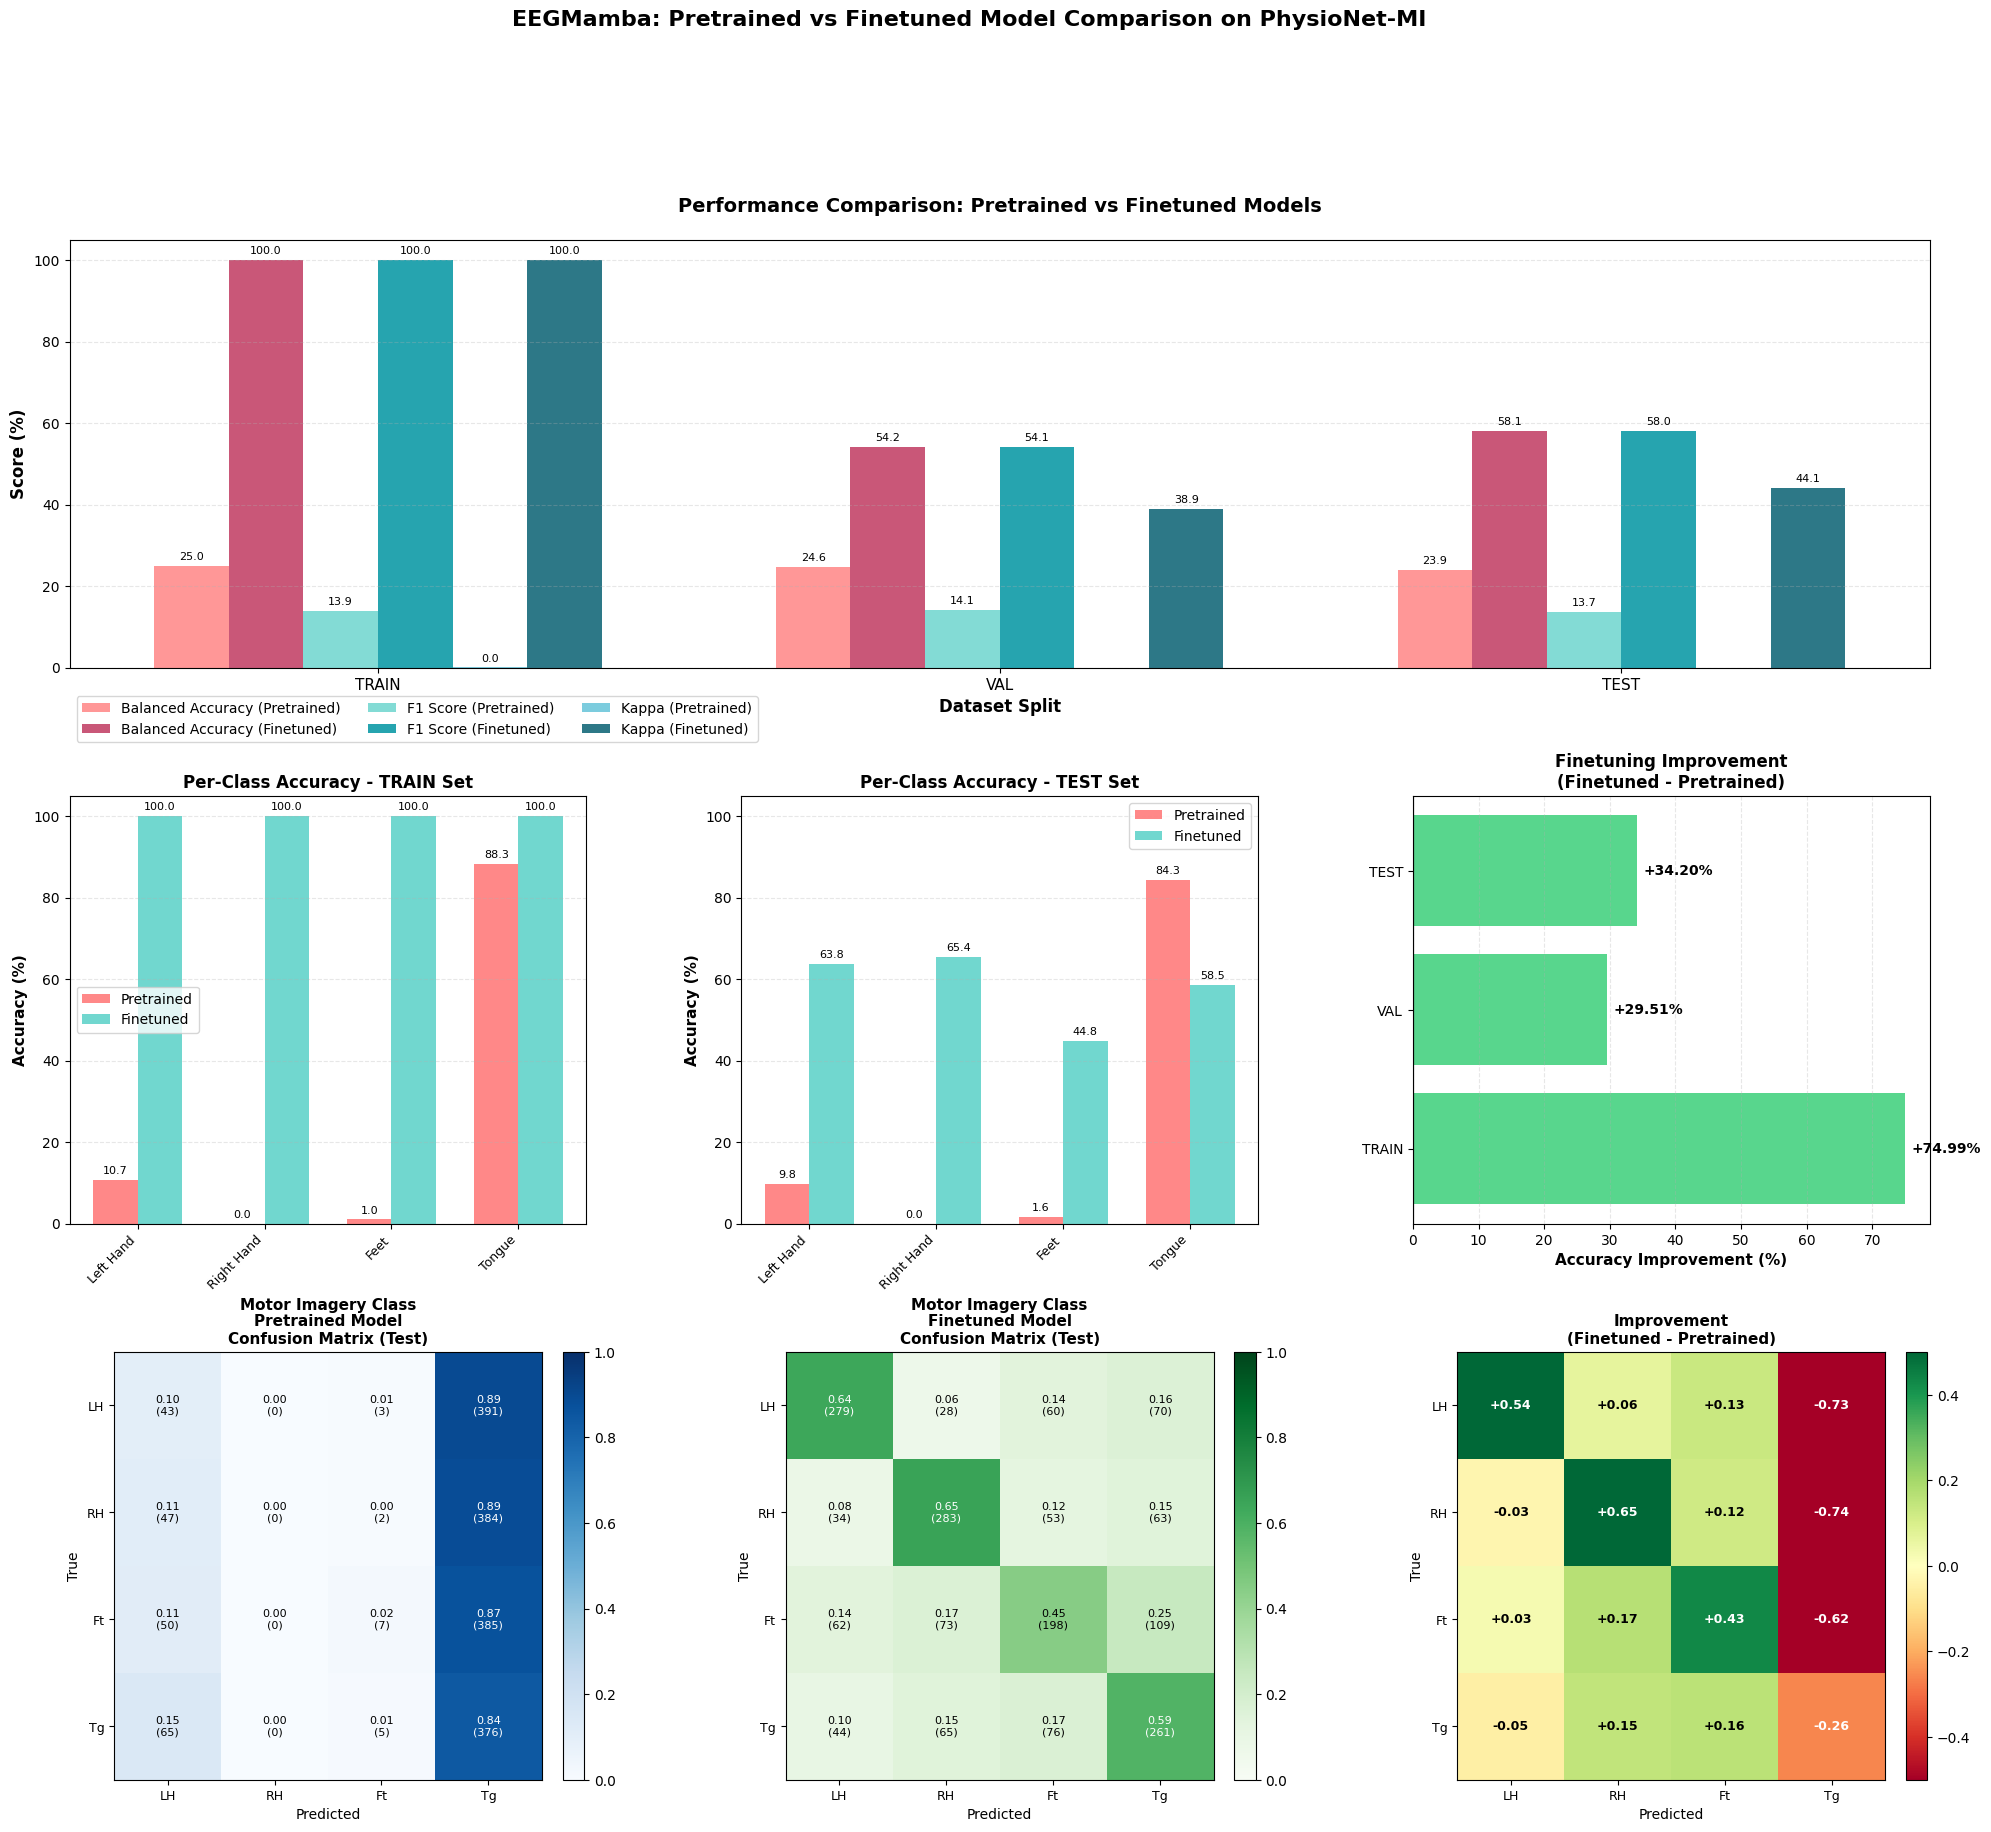


📊 DETAILED COMPARISON TABLE

Split Pretrained Acc Finetuned Acc   Acc Δ Pretrained F1 Finetuned F1    F1 Δ Pretrained κ Finetuned κ     κ Δ
TRAIN         25.01%       100.00% +74.99%        13.95%      100.00% +86.05%       0.0000      1.0000 +1.0000
  VAL         24.64%        54.15% +29.51%        14.12%       54.09% +39.97%      -0.0048      0.3887 +0.3935
 TEST         23.93%        58.13% +34.20%        13.72%       57.97% +44.25%      -0.0144      0.4410 +0.4554

📈 SUMMARY

🎯 Test Set Performance:
   • Pretrained:        23.93%
   • Finetuned:         58.13%
   • Absolute Δ:        +34.20 percentage points
   • Relative Δ:        +142.89%

✅ Finetuning improved test accuracy by 34.20 percentage points!




In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def compare_pretrained_vs_finetuned(pretrained_results, finetuned_results):
    """
    Create comprehensive comparison visualizations between pretrained and finetuned models
    
    Args:
        pretrained_results: Dictionary containing pretrained model results
        finetuned_results: Dictionary containing finetuned model results
    """
    
    if pretrained_results is None or finetuned_results is None:
        print("❌ Both pretrained and finetuned results are required!")
        print("💡 Make sure to run both evaluation cells first:")
        print("   1. Step 7: Evaluate Pretrained Model")
        print("   2. Step 8: Evaluate Finetuned Model")
        return
    
    print("📊 Generating Comparison Visualizations")
    print("="*80)
    
    # Define class names
    class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
    splits = ['train', 'val', 'test']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(24, 20))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Overall Performance Comparison (Bar Chart)
    ax1 = fig.add_subplot(gs[0, :])
    metrics = ['Balanced Accuracy', 'F1 Score', 'Kappa']
    
    x = np.arange(len(splits))
    width = 0.12
    
    for i, metric_key in enumerate(['balanced_accuracy', 'f1', 'kappa']):
        pretrained_vals = [pretrained_results[s].get(metric_key, pretrained_results[s].get('accuracy', 0)) 
                          for s in splits if s in pretrained_results]
        finetuned_vals = [finetuned_results[s][metric_key] for s in splits if s in finetuned_results]
        
        # Scale kappa to percentage for better visualization
        if metric_key == 'kappa':
            pretrained_vals = [v * 100 for v in pretrained_vals]
            finetuned_vals = [v * 100 for v in finetuned_vals]
        else:
            pretrained_vals = [v * 100 for v in pretrained_vals]
            finetuned_vals = [v * 100 for v in finetuned_vals]
        
        ax1.bar(x + i*width*2, pretrained_vals, width, 
               label=f'{metrics[i]} (Pretrained)', alpha=0.7, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'][i])
        ax1.bar(x + i*width*2 + width, finetuned_vals, width, 
               label=f'{metrics[i]} (Finetuned)', alpha=0.9,
               color=['#C44569', '#0E9AA7', '#16697A'][i])
    
    ax1.set_xlabel('Dataset Split', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Performance Comparison: Pretrained vs Finetuned Models', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(x + width * 2.5)
    ax1.set_xticklabels([s.upper() for s in splits], fontsize=11)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, -0.05), ncol=3, fontsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim([0, 105])
    
    # Add value labels on bars
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.1f', padding=3, fontsize=8)
    
    # 2. Per-Class Performance Comparison (for test set)
    for idx, split in enumerate(['train', 'test']):
        if split not in pretrained_results or split not in finetuned_results:
            continue
            
        ax = fig.add_subplot(gs[1, idx])
        
        pretrained_cm = pretrained_results[split]['confusion_matrix']
        finetuned_cm = finetuned_results[split]['confusion_matrix']
        
        # Calculate per-class accuracy
        pretrained_class_acc = []
        finetuned_class_acc = []
        
        for i in range(min(len(class_names), pretrained_cm.shape[0])):
            if pretrained_cm[i, :].sum() > 0:
                pretrained_class_acc.append(pretrained_cm[i, i] / pretrained_cm[i, :].sum() * 100)
            else:
                pretrained_class_acc.append(0)
                
            if finetuned_cm[i, :].sum() > 0:
                finetuned_class_acc.append(finetuned_cm[i, i] / finetuned_cm[i, :].sum() * 100)
            else:
                finetuned_class_acc.append(0)
        
        x_pos = np.arange(len(pretrained_class_acc))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, pretrained_class_acc, width, 
                      label='Pretrained', alpha=0.8, color='#FF6B6B')
        bars2 = ax.bar(x_pos + width/2, finetuned_class_acc, width, 
                      label='Finetuned', alpha=0.8, color='#4ECDC4')
        
        ax.set_xlabel('Motor Imagery Class', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
        ax.set_title(f'Per-Class Accuracy - {split.upper()} Set', 
                    fontsize=12, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(class_names[:len(pretrained_class_acc)], rotation=45, ha='right', fontsize=9)
        ax.legend(fontsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim([0, 105])
        
        # Add value labels
        ax.bar_label(bars1, fmt='%.1f', padding=3, fontsize=8)
        ax.bar_label(bars2, fmt='%.1f', padding=3, fontsize=8)
    
    # 3. Improvement Metrics
    ax_imp = fig.add_subplot(gs[1, 2])
    
    improvements = []
    improvement_labels = []
    
    for split in splits:
        if split in pretrained_results and split in finetuned_results:
            pretrained_acc = pretrained_results[split].get('balanced_accuracy', 
                                                          pretrained_results[split].get('accuracy', 0))
            finetuned_acc = finetuned_results[split]['balanced_accuracy']
            improvement = (finetuned_acc - pretrained_acc) * 100
            improvements.append(improvement)
            improvement_labels.append(split.upper())
    
    colors = ['#2ECC71' if imp > 0 else '#E74C3C' for imp in improvements]
    bars = ax_imp.barh(improvement_labels, improvements, color=colors, alpha=0.8)
    
    ax_imp.set_xlabel('Accuracy Improvement (%)', fontsize=11, fontweight='bold')
    ax_imp.set_title('Finetuning Improvement\n(Finetuned - Pretrained)', 
                    fontsize=12, fontweight='bold')
    ax_imp.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax_imp.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, improvements)):
        label_x = val + (1 if val > 0 else -1)
        ax_imp.text(label_x, i, f'{val:+.2f}%', 
                   va='center', ha='left' if val > 0 else 'right',
                   fontweight='bold', fontsize=10)
    
    # 4. Confusion Matrices Comparison (Test Set)
    if 'test' in pretrained_results and 'test' in finetuned_results:
        pretrained_cm = pretrained_results['test']['confusion_matrix']
        finetuned_cm = finetuned_results['test']['confusion_matrix']
        
        # Normalize confusion matrices
        pretrained_cm_norm = pretrained_cm.astype('float') / pretrained_cm.sum(axis=1)[:, np.newaxis]
        finetuned_cm_norm = finetuned_cm.astype('float') / finetuned_cm.sum(axis=1)[:, np.newaxis]
        
        # Pretrained CM
        ax_cm1 = fig.add_subplot(gs[2, 0])
        im1 = ax_cm1.imshow(pretrained_cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
        ax_cm1.set_title('Pretrained Model\nConfusion Matrix (Test)', fontsize=11, fontweight='bold')
        ax_cm1.set_xlabel('Predicted', fontsize=10)
        ax_cm1.set_ylabel('True', fontsize=10)
        
        tick_marks = np.arange(len(class_names[:pretrained_cm.shape[0]]))
        ax_cm1.set_xticks(tick_marks)
        ax_cm1.set_yticks(tick_marks)
        ax_cm1.set_xticklabels(['LH', 'RH', 'Ft', 'Tg'][:pretrained_cm.shape[0]], fontsize=9)
        ax_cm1.set_yticklabels(['LH', 'RH', 'Ft', 'Tg'][:pretrained_cm.shape[0]], fontsize=9)
        
        # Add text annotations
        for i in range(pretrained_cm_norm.shape[0]):
            for j in range(pretrained_cm_norm.shape[1]):
                text_color = 'white' if pretrained_cm_norm[i, j] > 0.5 else 'black'
                ax_cm1.text(j, i, f'{pretrained_cm_norm[i, j]:.2f}\n({pretrained_cm[i, j]})',
                          ha='center', va='center', color=text_color, fontsize=8)
        
        plt.colorbar(im1, ax=ax_cm1, fraction=0.046, pad=0.04)
        
        # Finetuned CM
        ax_cm2 = fig.add_subplot(gs[2, 1])
        im2 = ax_cm2.imshow(finetuned_cm_norm, interpolation='nearest', cmap='Greens', vmin=0, vmax=1)
        ax_cm2.set_title('Finetuned Model\nConfusion Matrix (Test)', fontsize=11, fontweight='bold')
        ax_cm2.set_xlabel('Predicted', fontsize=10)
        ax_cm2.set_ylabel('True', fontsize=10)
        
        ax_cm2.set_xticks(tick_marks)
        ax_cm2.set_yticks(tick_marks)
        ax_cm2.set_xticklabels(['LH', 'RH', 'Ft', 'Tg'][:finetuned_cm.shape[0]], fontsize=9)
        ax_cm2.set_yticklabels(['LH', 'RH', 'Ft', 'Tg'][:finetuned_cm.shape[0]], fontsize=9)
        
        for i in range(finetuned_cm_norm.shape[0]):
            for j in range(finetuned_cm_norm.shape[1]):
                text_color = 'white' if finetuned_cm_norm[i, j] > 0.5 else 'black'
                ax_cm2.text(j, i, f'{finetuned_cm_norm[i, j]:.2f}\n({finetuned_cm[i, j]})',
                          ha='center', va='center', color=text_color, fontsize=8)
        
        plt.colorbar(im2, ax=ax_cm2, fraction=0.046, pad=0.04)
        
        # Difference (Improvement) CM
        ax_cm3 = fig.add_subplot(gs[2, 2])
        diff_cm = finetuned_cm_norm - pretrained_cm_norm
        im3 = ax_cm3.imshow(diff_cm, interpolation='nearest', cmap='RdYlGn', vmin=-0.5, vmax=0.5)
        ax_cm3.set_title('Improvement\n(Finetuned - Pretrained)', fontsize=11, fontweight='bold')
        ax_cm3.set_xlabel('Predicted', fontsize=10)
        ax_cm3.set_ylabel('True', fontsize=10)
        
        ax_cm3.set_xticks(tick_marks)
        ax_cm3.set_yticks(tick_marks)
        ax_cm3.set_xticklabels(['LH', 'RH', 'Ft', 'Tg'][:diff_cm.shape[0]], fontsize=9)
        ax_cm3.set_yticklabels(['LH', 'RH', 'Ft', 'Tg'][:diff_cm.shape[0]], fontsize=9)
        
        for i in range(diff_cm.shape[0]):
            for j in range(diff_cm.shape[1]):
                text_color = 'white' if abs(diff_cm[i, j]) > 0.25 else 'black'
                ax_cm3.text(j, i, f'{diff_cm[i, j]:+.2f}',
                          ha='center', va='center', color=text_color, fontsize=9, fontweight='bold')
        
        plt.colorbar(im3, ax=ax_cm3, fraction=0.046, pad=0.04)
    
    plt.suptitle('EEGMamba: Pretrained vs Finetuned Model Comparison on PhysioNet-MI', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison table
    print("\n" + "="*80)
    print("📊 DETAILED COMPARISON TABLE")
    print("="*80 + "\n")
    
    # Create comparison dataframe
    comparison_data = []
    
    for split in splits:
        if split not in pretrained_results or split not in finetuned_results:
            continue
        
        pretrained_acc = pretrained_results[split].get('balanced_accuracy', 
                                                      pretrained_results[split].get('accuracy', 0))
        pretrained_f1 = pretrained_results[split].get('f1', 0)
        pretrained_kappa = pretrained_results[split].get('kappa', 0)
        
        finetuned_acc = finetuned_results[split]['balanced_accuracy']
        finetuned_f1 = finetuned_results[split]['f1']
        finetuned_kappa = finetuned_results[split]['kappa']
        
        comparison_data.append({
            'Split': split.upper(),
            'Pretrained Acc': f'{pretrained_acc*100:.2f}%',
            'Finetuned Acc': f'{finetuned_acc*100:.2f}%',
            'Acc Δ': f'{(finetuned_acc - pretrained_acc)*100:+.2f}%',
            'Pretrained F1': f'{pretrained_f1*100:.2f}%',
            'Finetuned F1': f'{finetuned_f1*100:.2f}%',
            'F1 Δ': f'{(finetuned_f1 - pretrained_f1)*100:+.2f}%',
            'Pretrained κ': f'{pretrained_kappa:.4f}',
            'Finetuned κ': f'{finetuned_kappa:.4f}',
            'κ Δ': f'{finetuned_kappa - pretrained_kappa:+.4f}'
        })
    
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "="*80)
    print("📈 SUMMARY")
    print("="*80)
    
    if 'test' in pretrained_results and 'test' in finetuned_results:
        test_pretrained = pretrained_results['test'].get('balanced_accuracy', 
                                                         pretrained_results['test'].get('accuracy', 0))
        test_finetuned = finetuned_results['test']['balanced_accuracy']
        improvement = (test_finetuned - test_pretrained) * 100
        relative_improvement = (improvement / (test_pretrained * 100)) * 100
        
        print(f"\n🎯 Test Set Performance:")
        print(f"   • Pretrained:        {test_pretrained*100:.2f}%")
        print(f"   • Finetuned:         {test_finetuned*100:.2f}%")
        print(f"   • Absolute Δ:        {improvement:+.2f} percentage points")
        print(f"   • Relative Δ:        {relative_improvement:+.2f}%")
        
        if improvement > 0:
            print(f"\n✅ Finetuning improved test accuracy by {improvement:.2f} percentage points!")
        elif improvement < 0:
            print(f"\n⚠️ Finetuning decreased test accuracy by {abs(improvement):.2f} percentage points")
        else:
            print(f"\n➖ No change in test accuracy after finetuning")
    
    print("\n" + "="*80 + "\n")

# Check if results exist and run comparison
print("🔍 Checking for evaluation results...")

if 'results' in locals() and 'finetuned_results' in locals():
    print("✅ Both pretrained and finetuned results found!")
    print("📊 Generating comparison...\n")
    compare_pretrained_vs_finetuned(results, finetuned_results)
elif 'results' in locals():
    print("⚠️ Only pretrained results found")
    print("💡 Please run Step 8: Evaluate Finetuned Model")
elif 'finetuned_results' in locals():
    print("⚠️ Only finetuned results found")
    print("💡 Please run Step 7: Evaluate Pretrained Model")
else:
    print("❌ No evaluation results found!")
    print("💡 Please run both evaluation steps:")
    print("   1. Step 7: Evaluate Pretrained Model")
    print("   2. Step 8: Evaluate Finetuned Model")